## Урок 4

### Деревья решений

#### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [42]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np

In [43]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(
    n_samples=5000,
    n_features = 2, 
    n_informative = 2, 
    n_classes = 2, 
    n_redundant=0, 
    n_clusters_per_class=1,
    random_state=99)

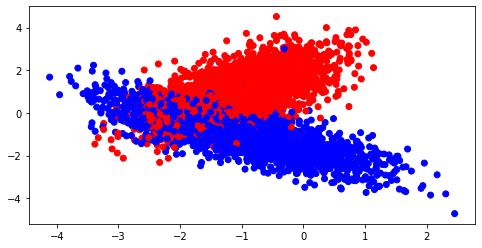

In [44]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,4))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [45]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [46]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [47]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [48]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [49]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [50]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [51]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth):
    depth = 1

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качестве
    # Или дерево имеет ограничение на глубине
    if quality == 0 or depth >= max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels,  max_depth)
    false_branch = build_tree(false_data, false_labels, max_depth)
    depth += 1

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)



In [52]:
def classify_object(obj, node, max_depth):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch, max_depth)
    else:
        return classify_object(obj, node.false_branch, max_depth)


In [53]:
def predict(data, tree, max_depth):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree, max_depth)
        classes.append(prediction)
    return classes

In [54]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [55]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth=2)

In [56]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree, max_depth=2)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree, max_depth=2)

In [57]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [58]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.31428571428572

In [59]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

85.93333333333332

Text(0.5, 1.0, 'Test accuracy=85.93')

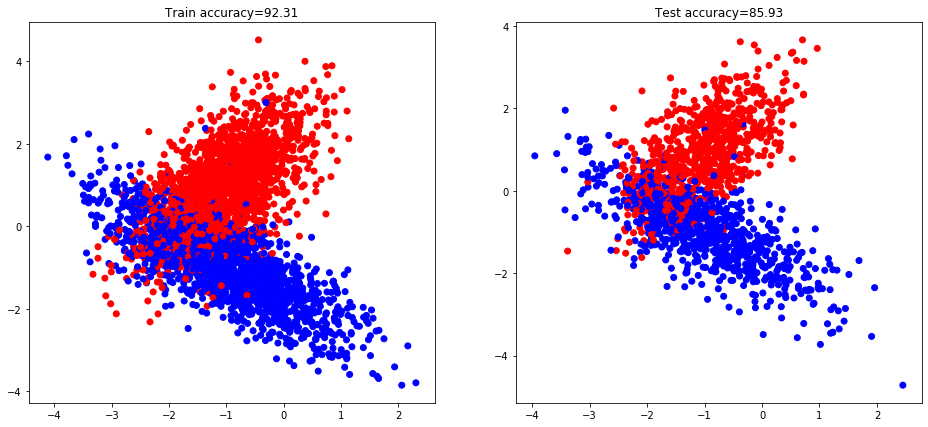

In [60]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
# mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
# plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
# plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

#### 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [34]:
def shannon_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p==0:
            impurity -= 0
        else:
            impurity -= p*np.log2(p)
    return impurity


# Расчет качества
def quality(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * shannon_entropy(left_labels) - (1 - p) * shannon_entropy(right_labels)


# Разбиение датасета в узле
def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)     
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right] 
    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    current_entropy = shannon_entropy(labels)
    best_quality = 0
    best_t = None
    best_index = None
    n_features = data.shape[1]
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth):
    depth = 1
    quality, t, index = find_best_split(data, labels)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качестве
    # Или дерево имеет ограничение на глубине
    if quality == 0 or depth >= max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels,  max_depth)
    false_branch = build_tree(false_data, false_labels, max_depth)
    depth += 1

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


def classify_object(obj, node, max_depth):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch, max_depth)
    else:
        return classify_object(obj, node.false_branch, max_depth)
    
    
def predict(data, tree, max_depth):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree, max_depth)
        classes.append(prediction)
    return classes

In [35]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [69]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth=2)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree, max_depth=2)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree, max_depth=2)

# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    return np.sum(actual==predicted)/len(actual)

def balanced_accuracy_metric(actual, predicted):
    true_predicted=(actual==predicted).astype(int)
    sensitivity=np.sum(actual*true_predicted)/np.sum(actual==1)
    specificity=np.sum((1-actual)*true_predicted)/np.sum(actual==0)
    return 0.5*(sensitivity+specificity)

In [70]:
# Точность на обучающей выборке
train_accuracy=accuracy_metric(train_labels, train_answers)
accuracy_metric(train_labels, train_answers), balanced_accuracy_metric(train_labels, train_answers)

(0.9231428571428572, 0.9231702251065964)

In [71]:
# Точность на тестовой выборке
test_accuracy=accuracy_metric(test_labels, answers)
accuracy_metric(test_labels, answers), balanced_accuracy_metric(test_labels, answers)

(0.8593333333333333, 0.8594274896088367)

Качество классификации с использованием индекса Джини и с использованием Энтропии Шеннона получилось одинаковым на данном датасете. При испытаниях на других датасетах разница между методами оказалась также незначительной.